In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model

In [33]:
def get_basket(*basket):

    i = 0
    while i < len(basket):
        basket[i].drop(['Time', 'Open', 'High', 'Low', 'Volume'], axis = 1, inplace = True)        
        basket[i]['Date'] = pd.to_datetime(basket[i]['Date'])
        i = i + 1
        
    # Frames start date alignment----------------------------------------------------
    start_date = basket[0]['Date'][0]
    for df in basket:
        if df['Date'][0] > start_date:
            start_date = df['Date'][0]
           
           
    for df in basket:
        if df['Date'][0] != start_date:
            index = df.loc[df['Date'] == start_date].index[0]
            df.drop(df.index[range(index)], inplace = True)
            df.reset_index(drop=True, inplace = True)
            
    # Frames end date alignment------------------------------------------------
    end_date = basket[0]['Date'][len(basket[0]['Date'])-1]
    for df in basket:
        if df['Date'][len(df['Date'])-1] < end_date:
            end_date = df['Date'][len(df['Date'])-1]
            
        
    for df in basket:
        if df['Date'][len(df['Date'])-1] != end_date:
            index = df.loc[df['Date'] == end_date].index[0]
            df.drop(df.index[range(index+1, len(df['Date']))], inplace = True)
            df.reset_index(drop=True, inplace = True)
    
    
    # Date alignment of all frames---------------------------------------------------    
    newDF = pd.date_range(start = start_date, end = end_date)
    maska = pd.DataFrame(data = newDF, columns = ['Date'])
    date = maska['Date'].tolist()

    basket_date = [0] * len(basket)
    basket_close = [0] * len(basket)
    for i in range(len(basket)):
        basket_date[i] = basket[i]['Date'].tolist()
        basket_close[i] = basket[i]['Close'].tolist()
    
    basket_d_c = basket_date + basket_close
    basket_list = [[0] * len(date) for i in range(len(basket_d_c))]    
    for i in range(len(basket)):
        for j in range(len(date)):
            if date[j] in basket_d_c[i]:
                basket_list[i][j] = date[j]
                basket_list[i+len(basket)][j] = basket_d_c[i+len(basket)][basket_d_c[i].index(date[j])]
            else:
                basket_list[i][j] = np.nan
                basket_list[i+len(basket)][j] = np.nan
    
    columns = [0] * len(basket_list)
    for i in range(len(basket)):
        columns[i] = 'Date_' + str(i)
        columns[i+len(basket)] = 'Close_' + str(i)
    
    
    basket_frame = pd.DataFrame()
    for i in range(len(basket_list)):
        basket_frame[str(i)] = basket_list[i]
    
    
    basket_frame.columns = columns
    basket_frame.dropna(inplace = True)
    basket_frame.reset_index(drop=True, inplace = True)
    basket_frame.drop(basket_frame.columns[[i for i in range(len(basket))]], axis = 1, inplace = True)
    
    # Get basket----------------------------------------------------------------------
    regr = linear_model.LinearRegression()
    x = basket_frame.iloc[range(len(basket_frame)), [i for i in range(1, len(basket))]]
    y = basket_frame.iloc[range(len(basket_frame)), 0]
    regr.fit(x, y)
    print ('Coefficients: ', regr.coef_)
    
    basket_frame['Basket'] = basket_frame['Close_0'] - regr.coef_[0] * basket_frame['Close_1']
    if len(basket) > 2:
        for i in range(2, len(basket)):
            basket_frame['Basket'] = basket_frame['Basket'] - regr.coef_[i-1] * basket_frame['Close_' + str(i)]            
    
    from statsmodels.tsa.stattools import adfuller
    X = basket_frame['Basket']
    result = adfuller(X)    
    print('p-value: ', result[1])
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    y = basket_frame['Basket']
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.axhline(y=(np.mean(y) + 2*np.std(y)), color='r', linestyle='--');
    plt.axhline(y=(np.mean(y) - 2*np.std(y)), color='r', linestyle='--');
    
    return plt.plot(y) 


Coefficients:  [0.02355317 0.00103426]
p-value:  0.004089598992124042


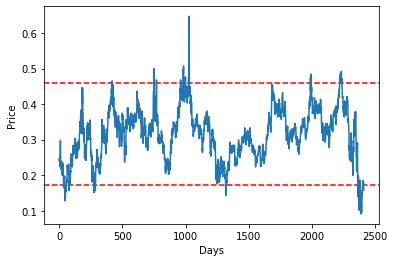

In [40]:
column_names = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']
df1 = pd.read_csv(r'D:\Trading\HO1440.csv', header = None, names = column_names)
df2 = pd.read_csv(r'D:\Trading\BRN1440.csv', header = None, names = column_names)
df3 = pd.read_csv(r'D:\Trading\ES1440.csv', header = None, names = column_names)
df4 = pd.read_csv(r'D:\Trading\CL1440.csv', header = None, names = column_names)
df5 = pd.read_csv(r'D:\Trading\AUDUSD1440.csv', header = None, names = column_names)
df6 = pd.read_csv(r'D:\Trading\GBPUSD1440.csv', header = None, names = column_names)
df7 = pd.read_csv(r'D:\Trading\NQ1440.csv', header = None, names = column_names)

get_basket(df1, df2, df4)